## Lesson 6: Bias and Variance / Hyperparameter and Validation Set
Readings:
- [5.3 Hyperparameters and Validation Sets](https://www.deeplearningbook.org/contents/ml.html) (p. 118)
- [5.4.4 Trading oﬀ Bias and Variance to Minimize Mean Squared Error](https://www.deeplearningbook.org/contents/ml.html) (p. 127)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

from implements_06.scripts_06 import *

pi = np.pi

Lesson structure:
- Bias and its correspondence to underfitting
- Variance and its correspondence to overfitting
- Hyperparameter optimization
- Validation sets

In [15]:
def format_plot(title, ax=None):
    fontdict={
        'fontsize': 15
    }
    if not ax:
        ax = plt.gca()
    plt.gcf().set_size_inches(8, 6)
    ax.set_xlabel('$X$', fontdict=fontdict)
    ax.set_ylabel('$f(X)$', fontdict=fontdict)
    ax.set_title(title, fontdict=fontdict)

---

Over- and under-fitting are two undesirable extremes in the spectrum of how well a model can [generalize](https://towardsdatascience.com/understand-neural-networks-model-generalization-7baddf1c48ca).
Both results in under-performance relative to optimal behavior.

While we have discussed how to diagnose and remedy these issues, it is also important to understand their underlying causes.
We have explained that overfitting occurs when the model capacity is too high, and underfitting occurs when it is too low.
This happens because of two types of error--**bias** and **variance**--and their relationship to model capacity.

Let's start by creating some sample data and training a regression model.

---

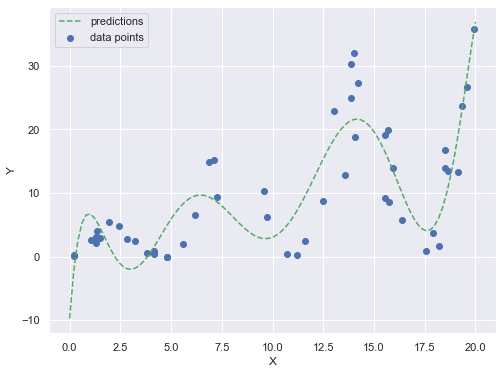

In [20]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline

def data_function(x):
    y_true = (np.sin(x)+1)*x
    noise = np.random.randn(*y_true.shape)*y_true/3
    return y_true+noise

N = 50
range_upper = 20
sample_X = np.random.random(N)*range_upper
sample_Y = data_function(sample_X)

order = 8
pipe = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=order, include_bias=False)),
    ('linear', linear_model.LinearRegression(fit_intercept=True))
])
pipe.fit(sample_X[...,None], sample_Y[...,None])
predictions_X = np.linspace(0,20,100)
predictions_Y = pipe.predict(predictions_X[...,None])[...,0]

plt.ylabel('Y')
plt.xlabel('X')
plt.scatter(sample_X, sample_Y, label='data points')
plt.plot(predictions_X, predictions_Y, 'g--', label='predictions')
plt.gcf().set_size_inches(8,6)
plt.legend();

---

We've already seen that by changing the number of polynomial terms, we can increase our **model capacity**, and vice-versa.

We have also discussed that in order to evaluate the performance of our model, we require splitting our data into training and testing subsets.
By calculating how well our model can **generalize** to our test set, we can judge whether we are in an under- or over-fitting regime.

Let's try this. How is the model performing? Is it underfitting or overfitting?

---

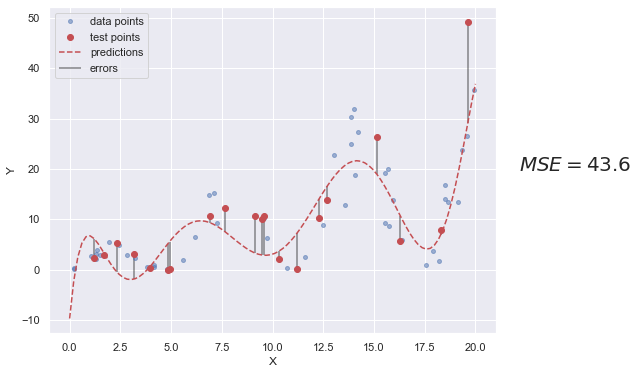

In [21]:
test_X = np.random.random(20)*20
test_Y = data_function(test_X)

MSE = ((test_Y-pipe.predict(test_X[...,None])[...,0])**2).mean()

plt.ylabel('Y')
plt.xlabel('X')
plt.plot(sample_X, sample_Y, 'bo', markersize=4, alpha=0.5, label='data points')
plt.plot(test_X, test_Y,'ro', label='test points')
plt.vlines(test_X, test_Y, pipe.predict(test_X[...,None])[...,0], alpha=0.5, label='errors')
plt.plot(predictions_X, predictions_Y, 'r--', label='predictions')
plt.gcf().set_size_inches(8,6)

plt.gcf().text(0.94,0.5,'$MSE = '+str(round(MSE,1))+'$', fontdict={'fontsize':20})
plt.legend();

---
## Bias

This raises new questions: why do these errors occur, and how can we formalize them mathematically?

Underfitting can be explained by **bias**. Bias measures the expected deviation from the true value of the function, independent of the particular sampling.

To illustrate, take the following noisy function:

---

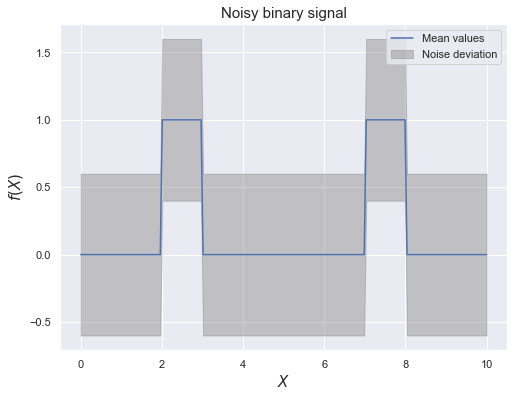

In [24]:
def f(x):
    y_clean = f_noiseless(x)
    y = y_clean + (np.random.randn(len(x))-0.5)*0.6
    return y

def f_noiseless(x):
    y_clean = (((x>=2) & (x<=3)) | ((x>=7) & (x<=8))).astype(np.int32)
    return y_clean
    
X = np.linspace(0,10,200)
Y = f_noiseless(np.linspace(0,10,200))
plt.plot(X, Y, label='Mean values')
plt.fill_between(X, Y-0.6, Y+0.6, color='gray', alpha=0.4, label='Noise deviation')
plt.legend()
format_plot('Noisy binary signal')

---

Let's try to model this distribution using [K-Nearest-Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

Let's sample some data from the distribution, then model it with KNN. Note that we are limited in how accurately we can model it, due to the Bayes error caused by the data's randomness.

---

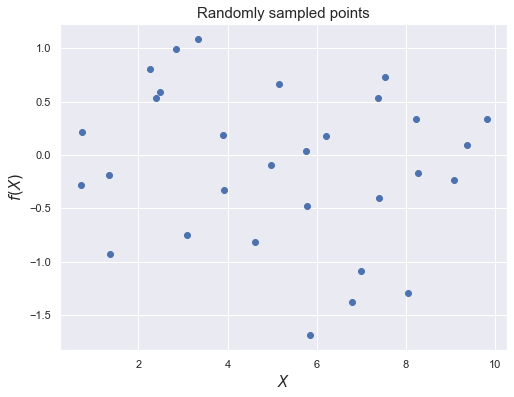

In [56]:
X = np.random.random((30))*10

plt.scatter(X, f(X))
format_plot('Randomly sampled points')

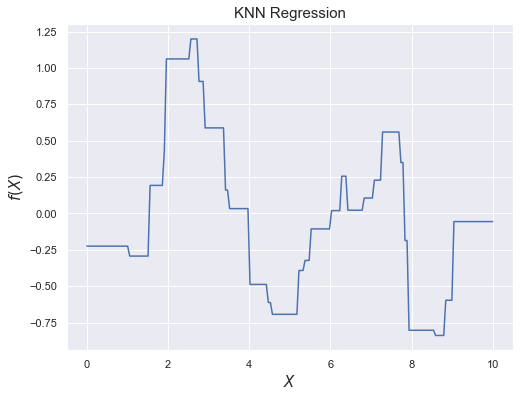

In [57]:
from sklearn import neighbors

# using K=3
KNN_model = neighbors.KNeighborsRegressor(3)
KNN_model.fit(X[...,None], f(X)[...,None])

X_test = np.linspace(0,10,200)
predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
plt.plot(X_test, predictions)
format_plot('KNN Regression')

---

We can plot an error curve for this model as a functino of x:

---

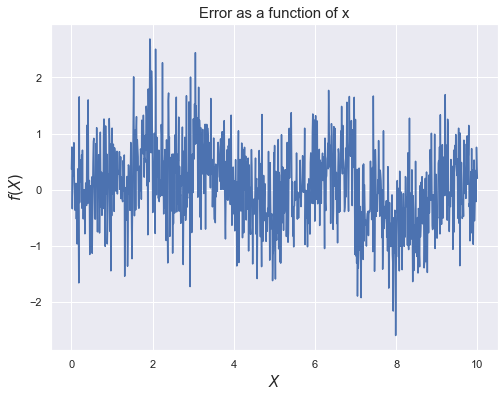

Mean error: 0.06294775620043618 (sampled on 1000 points)


In [58]:
def get_errors(preds, y):
    return preds-y

X_test = np.linspace(0,10,1000)

errors = get_errors(KNN_model.predict(X_test[...,None])[:,0], f(X_test))

plt.plot(X_test, errors)
format_plot('Error as a function of x')
plt.show()

print("Mean error: {} (sampled on {} points)".format(errors.mean(), len(X_test)))

--- 

Wow, that's a very noisy estimator.

To find the bias of this methodology, we need to find the expected errors of this model.

We will approximate these values by taking the average over many different versions of the KNN_model, with different, random training set samples.

---

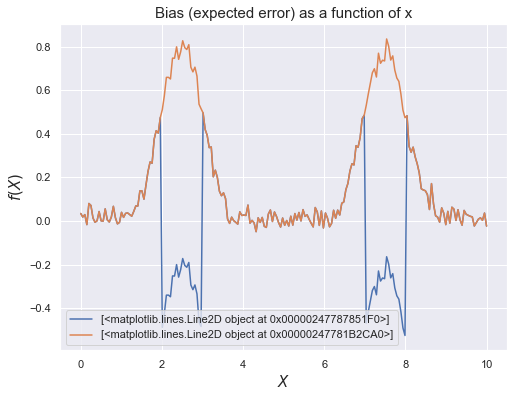

In [67]:
K = 3
X_N = 30 
N = 500

X_test = np.linspace(0,10,200)
errs = []
for _ in range(N):
    X = np.random.random((X_N))*10
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    errs.append(get_errors(predictions, f(X_test)))
    
errs = np.asarray(errs)
avgs = errs.mean(axis=0)
a  = plt.plot(X_test, avgs, label='Bias')

avgs += f_noiseless(X_test)
b = plt.plot(X_test, avgs, label='Bias+Truth')
 
format_plot('Bias (expected error) as a function of x')

plt.legend([a,b])
plt.show()

---

Isn't that interesting? Our model consistently underestimates the values around the two peaks, and overestimates the rest. 
In fact, if we add our true values, our predictions seem to take the form of a [bimodal gaussian](https://en.wikipedia.org/wiki/Multimodal_distribution) distribution! [I wonder why...](https://en.wikipedia.org/wiki/Central_limit_theorem)

Feel free to change the model and data parameters to see what happens.

**Bias** is the primary cause of underfitting. We can see a high bias in this particular model because of it's low capacity. In the case of KNN, the capacity is a function of the sample size.
This is because each data point can be thought of as a model parameter, and is used in the prediction calculation. 
For this reason, KNN performs poorly with very large datasets--the distance to each training point must be calculated for prediction.

Try for yourself!

---

---

## Variance
The second primary source of generalization error is **variance**--the deviation from the expected estimator value that any particular sampling will cause.
This can be thought of as an instability to changes in the training points. 
If your model changes drastically with different training samples, then it is likely **overfitting** to the training data.

Let's try calculating this for the KNN model we just used!

---

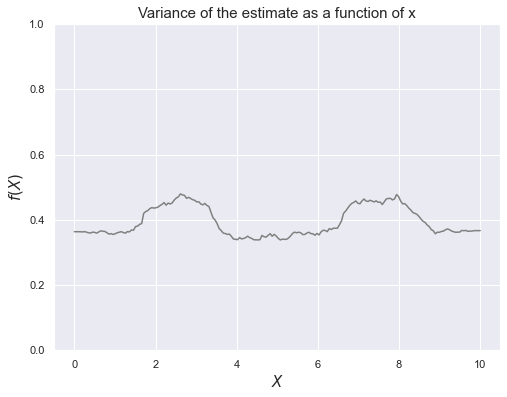

In [68]:
K = 3 
X_N = 30
N = 500

X_test = np.linspace(0,10,200)
Y_test = f(X_test)
errs = []
for _ in range(N):
    X = np.random.random((X_N))*10
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    
#     errs.append(get_errors(predictions, f(X_test)))
    errs.append(get_errors(predictions, Y_test))
    
errs = np.asarray(errs)
std_err = errs.std(axis=0)

# plt.plot(X_test, avgs)
plt.plot(X_test, std_err, color='gray')
plt.ylim(0,1)
format_plot('Variance of the estimate as a function of x')
plt.show()

--- 

As we saw, increasing the sample size also increases the model capacity, and so it does not significantly decrease model variance.

---

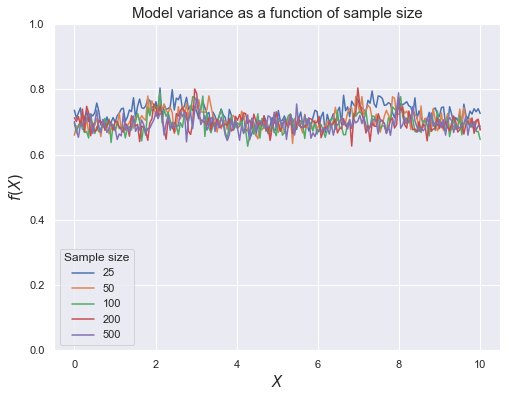

In [71]:
K = 3 
N = 500

for X_N in [25,50,100,200,500]:
    X_test = np.linspace(0,10,200)
    errs = []
    for _ in range(N):
        X = np.random.random((X_N))*10
        KNN_model = neighbors.KNeighborsRegressor(K)
        KNN_model.fit(X[...,None], f(X)[...,None])

        predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
        errs.append(get_errors(predictions, f(X_test)))
    
    errs = np.asarray(errs)
    std_err = errs.std(axis=0)
    plt.plot(X_test, std_err, label=X_N)

format_plot('Model variance as a function of sample size')
plt.legend(title='Sample size')
plt.ylim(0,1)
plt.show()

---

We have one more parameter to play with, **K**. This parameter affects how many nearby points the model uses to make its estimate.
By using more points, we average over a larger number of values which, reduces the effect of noise on our estimate thanks to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

By averaging over more points, we are effectively smoothing our predictions.
This has the effect of **decreasing model capacity** (do you see why?).

*Why not try increasing K to see how it affects the model bias as well?*

---

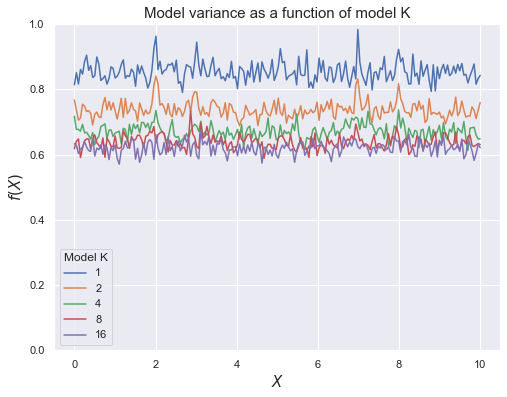

In [73]:
X_N = 200
N = 500

for K in [1,2,4,8,16]:
    X_test = np.linspace(0,10,200)
    errs = []
    for _ in range(N):
        X = np.random.random((X_N))*10
        KNN_model = neighbors.KNeighborsRegressor(K)
        KNN_model.fit(X[...,None], f(X)[...,None])

        predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
        errs.append(get_errors(predictions, f(X_test)))
    
    errs = np.asarray(errs)
    std_err = errs.std(axis=0)
    plt.plot(X_test, std_err, label=K)

format_plot('Model variance as a function of model K')
plt.legend(title='Model K')
plt.ylim(0,1)
plt.show()

---

What do you think our predictions look like as we increase K? 
Give this some thought before running the next portion.

---

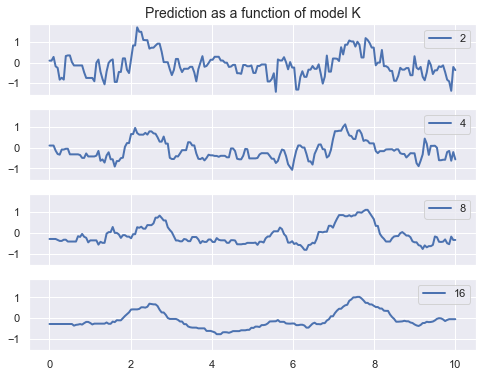

In [74]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True)
X_N = 200
X_test = np.linspace(0,10,200)
X = np.random.random((X_N))*10

for i, K in enumerate([2,4,8,16]):
    errs = []
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    ax[i].plot(X_test, predictions, label=K, lw=2)
    ax[i].legend(loc='upper right')

ax[0].set_title('Prediction as a function of model K', fontdict={'fontsize':14})
fig.set_size_inches(8,6)
plt.show();

---

## Hyperparameters

While I called K a 'parameter', the term can be confusing. For many models, 'parameters' can also refer to the coefficients a model learns during the training process. For this reason, model parameters such as K that are determined before training are normally referred to as **hyperparameters**.

Some examples of hyperparameters are:
- The number of layers in a deep learning model
- The order of a polynomial regression
- The limit on the depth of a tree classifier
- The number of clusters in a K-means clustering model]

Some models can have a very high number of hyperparameters, which begs the question: how do we know what values to use?
The answer for most cases is that we don't. Because of the variety of functions and distributions machine learning models can model, different models may require very different parameters, with varying degrees of success.
As a model designer, the solution is to look for the hyperparameter values approproate for your specific application.
This can be done manually, but typically requires a large amount of experience and knowledge both about the mathematics behind the model and the domain of the problem.
An easier approach that anyone can attempt is to algorithmically search for the best values. In either case, the process of searching for the best hyperparameters is called **hyperparamenter tuning**.

---

---

### Hyperparameter tuning and validation sets

To find the ideal hyperparameters, we must first define "ideal". Much like how we define loss functions, we must decide on a metric with which we can evaluate the success of our training process.
Typical metrics are **test loss** and **training time**. 
We will then iteratively generate hyperparameters, train our model using those values, and evaluate the results with our chosen metric.

For automated hyperparameter optimization, we must also choose a method for generating the values of our hyperparameters. The two most common methods are **grid search**, **random search**.

Grid search consists of defining a range of possible values for each hyperparameter and evenly splitting that space into a grid. Each vertex of that grid is a combination of hyperparameters which we will use to train our model.

---

---

In random search, we pick points at random from that range, rather than evenly spaced points. This method greatly outperforms grid search, for mathematical reasons we will not go into. For specifics, please read section 11.4 of the [book](https://www.deeplearningbook.org/contents/guidelines.html). 
In short, random search does not waste computation by checking the same parameter values several times, as grid search does. This is important because of the uneven distribution of parameter importance. 
Typically, few hyperparameters have a disproportionally large effect on the result. While grid search repeats a few values of the important parameters many times, random search checks a different value at each iteration.

While other hyperparameter optimization methods exist, they are not unambiguously better than random search.

---

</br>
<img src="implements_06/grid vs random.PNG" />
</br>